# Introduction

Notebook to analyze the **True Positive** Results for each model in the context of traceability between features and bug reports.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

from modules.models_runner.feat_br_models_runner import Feat_BR_Models_Runner
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import aux_functions
from modules.utils import model_evaluator as m_eval
from modules.utils import similarity_measures as sm
from modules.utils import tokenizers as tok

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Volunteers Only Strategy

In [2]:
models_runner_4 = Feat_BR_Models_Runner()
lsi_model_4 = models_runner_4.run_lsi_model()
lda_model_4 = models_runner_4.run_lda_model()
bm25_model_4 = models_runner_4.run_bm25_model()
w2v_model_4 = models_runner_4.run_word2vec_model()

oracle = fd.Feat_BR_Oracles.read_feat_br_volunteers_df().T

evaluator_4 = m_eval.ModelEvaluator(oracle)
evals_df_4 = evaluator_4.run_evaluator(models=[lsi_model_4,lda_model_4,bm25_model_4,w2v_model_4],
                                       top_values=[1,3,5], 
                                       sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Feat_BR Volunteers Matrix shape: (91, 19)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Load Datasets

In [3]:
bugreports = fd.Datasets.read_selected_bugreports_df()
features = fd.Datasets.read_features_df()

SelectedBugReports.shape: (91, 18)
Features.shape: (19, 8)


### Tokenization

In [4]:
tokenizer = tok.PorterStemmerBased_Tokenizer()
bugreports['tokens'] = bugreports.apply(lambda row : tokenizer.__call__(row['br_desc']), axis=1)
features['tokens'] = features.apply(lambda row : tokenizer.__call__(row['feat_desc']), axis=1)

### Results

In [5]:
evals_df_4.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_1_cosine_0.1,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.1,1.0,Bug_Number 1248267 1248268 125...
2,lsi,top_1_cosine_0.2,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.2,1.0,Bug_Number 1248267 1248268 125...
3,lsi,top_1_cosine_0.3,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.3,1.0,Bug_Number 1248267 1248268 125...
4,lsi,top_1_cosine_0.4,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.4,1.0,Bug_Number 1248267 1248268 125...


### Grouping Results by Model

#### Min Precision

model
bm25          11.87
lda            1.10
lsi           12.53
wordvector     7.64
Name: perc_precision, dtype: float64



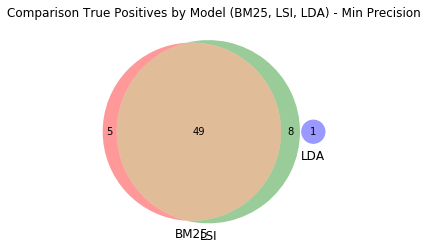

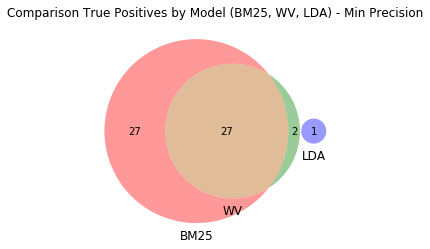

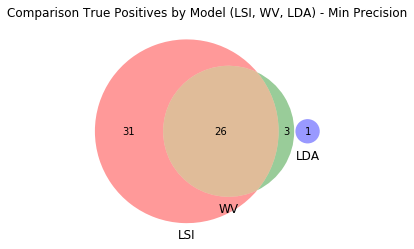

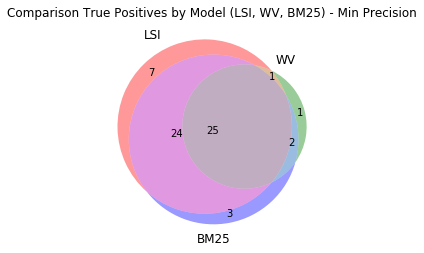

In [17]:
group = evals_df_4.groupby('model').perc_precision.min()
print(group)
print()

bm25_min_prec = group[group.index == 'bm25'].values[0]
lsi_min_prec = group[group.index == 'lsi'].values[0]
lda_min_prec = group[group.index == 'lda'].values[0]
wv_min_prec = group[group.index == 'wordvector'].values[0]

bm25_tp_set_min_prec = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_min_prec))
lsi_tp_set_min_prec = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_min_prec))
lda_tp_set_min_prec = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_min_prec))
wv_tp_set_min_prec = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_min_prec))

venn3([bm25_tp_set_min_prec, lsi_tp_set_min_prec, lda_tp_set_min_prec], ['BM25','LSI','LDA'])
plt.title('Comparison True Positives by Model (BM25, LSI, LDA) - Min Precision')
plt.show()

venn3([bm25_tp_set_min_prec, wv_tp_set_min_prec, lda_tp_set_min_prec], ['BM25','WV','LDA'])
plt.title('Comparison True Positives by Model (BM25, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_tp_set_min_prec, wv_tp_set_min_prec, lda_tp_set_min_prec], ['LSI','WV','LDA'])
plt.title('Comparison True Positives by Model (LSI, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_tp_set_min_prec, wv_tp_set_min_prec, bm25_tp_set_min_prec], ['LSI','WV','BM25'])
plt.title('Comparison True Positives by Model (LSI, WV, BM25) - Min Precision')
plt.show()

##### Exclusive Cases

In [18]:
print("BM25 Exclusive TP:")
bm25_exc_set_min_prec = bm25_tp_set_min_prec - lsi_tp_set_min_prec - lda_tp_set_min_prec - wv_tp_set_min_prec
display(bm25_exc_set_min_prec)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set_min_prec)))

print("\n\nLSI Exclusive TP:")
lsi_exc_set_min_prec = lsi_tp_set_min_prec - bm25_tp_set_min_prec - lda_tp_set_min_prec - wv_tp_set_min_prec
display(lsi_exc_set_min_prec)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set_min_prec)))

print("\n\nLDA Exclusive TP:")
lda_exc_set_min_prec = lda_tp_set_min_prec - lsi_tp_set_min_prec - bm25_tp_set_min_prec - wv_tp_set_min_prec
display(lda_exc_set_min_prec)
print("len(lda_exc_set): {}".format(len(lda_exc_set_min_prec)))

print("\n\nWV Exclusive TP:")
wv_exc_set_min_prec = wv_tp_set_min_prec - lda_tp_set_min_prec - lsi_tp_set_min_prec - bm25_tp_set_min_prec
display(wv_exc_set_min_prec)
print("len(wv_exc_set): {}".format(len(wv_exc_set_min_prec)))

BM25 Exclusive TP:


{('downloads_dropmaker', 1432915),
 ('flac_support', 1295502),
 ('pointer_lock_api', 1314643)}

len(bm25_exc_set): 3


LSI Exclusive TP:


{('browser_customization', 1301784),
 ('browser_customization', 1344446),
 ('pdf_viewer', 1301056),
 ('pdf_viewer', 1365887),
 ('tts_in_rm', 1335538),
 ('w10_comp', 1279140),
 ('webgl_comp', 1295502)}

len(lsi_exc_set): 7


LDA Exclusive TP:


{('webgl_comp', 1312018)}

len(lda_exc_set): 1


WV Exclusive TP:


{('new_awesome_bar', 1313778)}

len(wv_exc_set): 1


In [19]:
aux_functions.detail_features_br(lda_exc_set_min_prec, features=features, bugreports=bugreports)

,feat,feat_desc,br,br_summary
0,webgl_comp,"Feature of Firefox implemted based on WebGL library for the rendering of games, animations and graphs in the web browser.",1312018,Keyword search is always performed in lowercase


##### Word Clouds

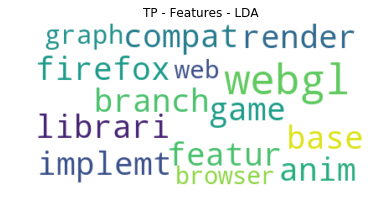

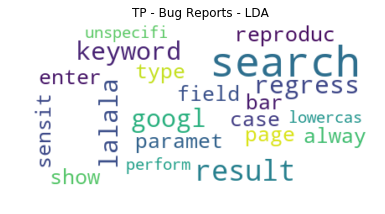

In [20]:
aux_functions.create_wordcloud_feat_br(lda_exc_set_min_prec, bugreports=bugreports, features=features,
                                     wc_feat_title="TP - Features - LDA",
                                     wc_br_title="TP - Bug Reports - LDA")

##### True Positives Amount by Model

In [21]:
print("LSI TP Amount: {}".format(len(lsi_tp_set_min_prec)))
print("LDA TP Amount: {}".format(len(lda_tp_set_min_prec)))
print("BM25 TP Amount: {}".format(len(bm25_tp_set_min_prec)))
print("WV TP Amount: {}".format(len(wv_tp_set_min_prec)))

LSI TP Amount: 57
LDA TP Amount: 1
BM25 TP Amount: 54
WV TP Amount: 29


#### Max Precision

model
bm25          30.77
lda           13.19
lsi           31.32
wordvector    17.58
Name: perc_precision, dtype: float64



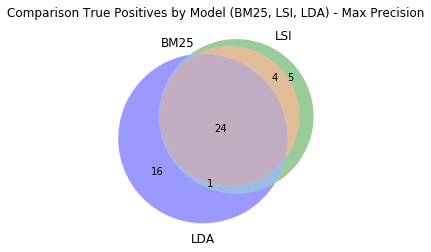

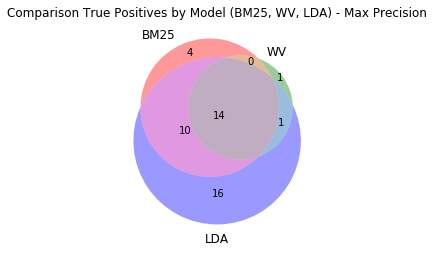

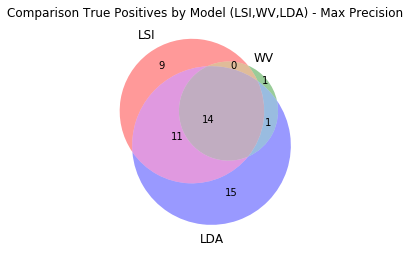

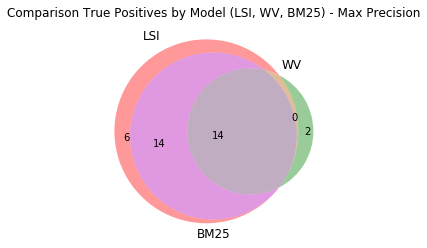

In [22]:
group = evals_df_4.groupby('model').perc_precision.max()
print(group)
print()

bm25_max_prec = group[group.index == 'bm25'].values[0]
lsi_max_prec = group[group.index == 'lsi'].values[0]
lda_max_prec = group[group.index == 'lda'].values[0]
wv_max_prec = group[group.index == 'wordvector'].values[0]

bm25_tp_set_max_prec = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_max_prec))
lsi_tp_set_max_prec = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_max_prec))
lda_tp_set_max_prec = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_max_prec))
wv_tp_set_max_prec = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_max_prec))

venn3([bm25_tp_set_max_prec, lsi_tp_set_max_prec, lda_tp_set_max_prec], ['BM25','LSI','LDA'])
plt.title('Comparison True Positives by Model (BM25, LSI, LDA) - Max Precision')
plt.show()

venn3([bm25_tp_set_max_prec, wv_tp_set_max_prec, lda_tp_set_max_prec], ['BM25','WV','LDA'])
plt.title('Comparison True Positives by Model (BM25, WV, LDA) - Max Precision')
plt.show()

venn3([lsi_tp_set_max_prec, wv_tp_set_max_prec, lda_tp_set_max_prec], ['LSI','WV','LDA'])
plt.title('Comparison True Positives by Model (LSI,WV,LDA) - Max Precision')
plt.show()

venn3([lsi_tp_set_max_prec, wv_tp_set_max_prec, bm25_tp_set_max_prec], ['LSI','WV','BM25'])
plt.title('Comparison True Positives by Model (LSI, WV, BM25) - Max Precision')
plt.show()

##### Exclusive Cases

In [23]:
print("BM25 Exclusive TP:")
bm25_exc_set_max_prec = bm25_tp_set_max_prec - lsi_tp_set_max_prec - lda_tp_set_max_prec - wv_tp_set_max_prec
display(bm25_exc_set_max_prec)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set_max_prec)))

print("\n\nLSI Exclusive TP:")
lsi_exc_set_max_prec = lsi_tp_set_max_prec - bm25_tp_set_max_prec - lda_tp_set_max_prec - wv_tp_set_max_prec
display(lsi_exc_set_max_prec)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set_max_prec)))

print("\n\nLDA Exclusive TP:")
lda_exc_set_max_prec = lda_tp_set_max_prec - lsi_tp_set_max_prec - bm25_tp_set_max_prec - wv_tp_set_max_prec
display(lda_exc_set_max_prec)
print("len(lda_exc_set): {}".format(len(lda_exc_set_max_prec)))

print("\n\nWV Exclusive TP:")
wv_exc_set_max_prec = wv_tp_set_max_prec - lda_tp_set_max_prec - lsi_tp_set_max_prec - bm25_tp_set_max_prec
display(wv_exc_set_max_prec)
print("len(wv_exc_set): {}".format(len(wv_exc_set_max_prec)))

BM25 Exclusive TP:


set()

len(bm25_exc_set): 0


LSI Exclusive TP:


{('browser_customization', 1353831),
 ('browser_customization', 1451475),
 ('downloads_dropmaker', 1292573),
 ('pdf_viewer', 1301056),
 ('zoom_indicator', 1305195)}

len(lsi_exc_set): 5


LDA Exclusive TP:


{('context_menu', 1313969),
 ('context_menu', 1365887),
 ('flac_support', 1295502),
 ('flash_support', 1295502),
 ('new_awesome_bar', 1271607),
 ('new_awesome_bar', 1278388),
 ('new_awesome_bar', 1279143),
 ('new_awesome_bar', 1297336),
 ('new_awesome_bar', 1305737),
 ('new_awesome_bar', 1328913),
 ('new_awesome_bar', 1352539),
 ('w10_comp', 1279140),
 ('w10_comp', 1303339),
 ('webgl_comp', 1312018),
 ('webgl_comp', 1365887)}

len(lda_exc_set): 15


WV Exclusive TP:


{('apz_async_scrolling', 1287687)}

len(wv_exc_set): 1


##### Word Clouds

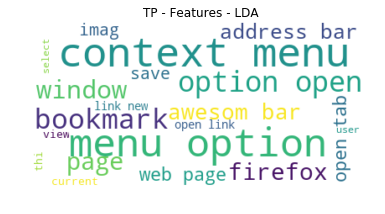

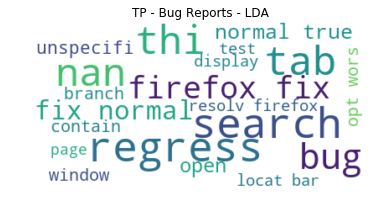

In [24]:
aux_functions.create_wordcloud_feat_br(lda_exc_set_max_prec, bugreports=bugreports, features=features,
                                     wc_feat_title="TP - Features - LDA",
                                     wc_br_title="TP - Bug Reports - LDA")

##### True Positives Amount by Model

In [25]:
print("LSI TP Amount: {}".format(len(lsi_tp_set_max_prec)))
print("LDA TP Amount: {}".format(len(lda_tp_set_max_prec)))
print("BM25 TP Amount: {}".format(len(bm25_tp_set_max_prec)))
print("WV TP Amount: {}".format(len(wv_tp_set_max_prec)))

LSI TP Amount: 34
LDA TP Amount: 41
BM25 TP Amount: 28
WV TP Amount: 16


#### Max-Min Precision Comparison by Model

In [26]:
print("LSI")
display(lsi_tp_set_max_prec - lsi_tp_set_min_prec)

print("LDA")
display(lda_tp_set_max_prec - lda_tp_set_min_prec)

print("BM25")
display(bm25_tp_set_max_prec - bm25_tp_set_min_prec)

print("WV")
display(wv_tp_set_max_prec - wv_tp_set_min_prec)

LSI


set()

LDA


{('context_menu', 1248267),
 ('context_menu', 1270983),
 ('context_menu', 1299458),
 ('context_menu', 1313969),
 ('context_menu', 1365887),
 ('downloads_dropmaker', 1287384),
 ('flac_support', 1295502),
 ('flash_support', 1295502),
 ('new_awesome_bar', 1264988),
 ('new_awesome_bar', 1271607),
 ('new_awesome_bar', 1276120),
 ('new_awesome_bar', 1278388),
 ('new_awesome_bar', 1279143),
 ('new_awesome_bar', 1279864),
 ('new_awesome_bar', 1291770),
 ('new_awesome_bar', 1293308),
 ('new_awesome_bar', 1294733),
 ('new_awesome_bar', 1294887),
 ('new_awesome_bar', 1296366),
 ('new_awesome_bar', 1297336),
 ('new_awesome_bar', 1297374),
 ('new_awesome_bar', 1297976),
 ('new_awesome_bar', 1301421),
 ('new_awesome_bar', 1305737),
 ('new_awesome_bar', 1309856),
 ('new_awesome_bar', 1311998),
 ('new_awesome_bar', 1328913),
 ('new_awesome_bar', 1334844),
 ('new_awesome_bar', 1335992),
 ('new_awesome_bar', 1337682),
 ('new_awesome_bar', 1339497),
 ('new_awesome_bar', 1352539),
 ('new_awesome_bar', 135

BM25


set()

WV


{('context_menu', 1270983),
 ('new_awesome_bar', 1297976),
 ('new_awesome_bar', 1335992)}

#### Min Recall

model
bm25          28.38
lda            1.10
lsi           13.32
wordvector    12.77
Name: perc_recall, dtype: float64



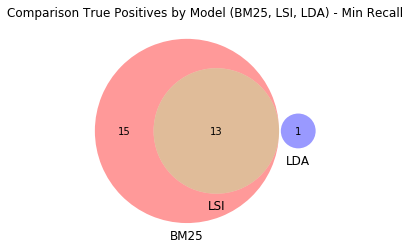

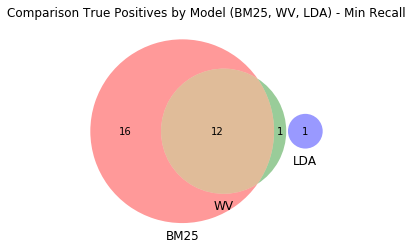

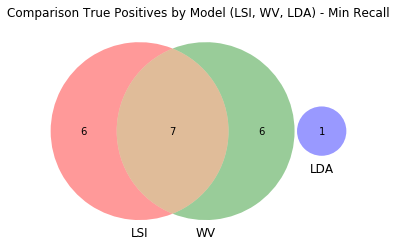

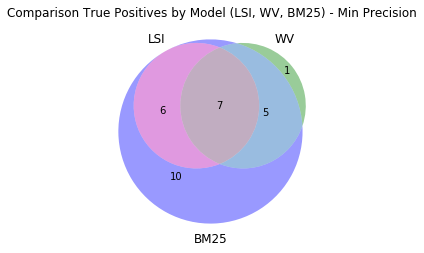

In [27]:
group = evals_df_4.groupby('model').perc_recall.min()
print(group)
print()

bm25_min_recall = group[group.index == 'bm25'].values[0]
lsi_min_recall = group[group.index == 'lsi'].values[0]
lda_min_recall = group[group.index == 'lda'].values[0]
wv_min_recall = group[group.index == 'wordvector'].values[0]

bm25_tp_set_min_recall = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_min_recall))
lsi_tp_set_min_recall = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_min_recall))
lda_tp_set_min_recall = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_min_recall))
wv_tp_set_min_recall = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_min_recall))

venn3([bm25_tp_set_min_recall, lsi_tp_set_min_recall, lda_tp_set_min_recall], ['BM25','LSI','LDA'])
plt.title('Comparison True Positives by Model (BM25, LSI, LDA) - Min Recall')
plt.show()

venn3([bm25_tp_set_min_recall, wv_tp_set_min_recall, lda_tp_set_min_recall], ['BM25','WV','LDA'])
plt.title('Comparison True Positives by Model (BM25, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_tp_set_min_recall, wv_tp_set_min_recall, lda_tp_set_min_recall], ['LSI','WV','LDA'])
plt.title('Comparison True Positives by Model (LSI, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_tp_set_min_recall, wv_tp_set_min_recall, bm25_tp_set_min_recall], ['LSI','WV','BM25'])
plt.title('Comparison True Positives by Model (LSI, WV, BM25) - Min Precision')
plt.show()

##### Exclusive Cases

In [28]:
print("BM25 Exclusive TP:")
bm25_exc_set_min_recall = bm25_tp_set_min_recall - lsi_tp_set_min_recall - lda_tp_set_min_recall - wv_tp_set_min_recall
display(bm25_exc_set_min_recall)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set_min_recall)))

print("\n\nLSI Exclusive TP:")
lsi_exc_set_min_recall = lsi_tp_set_min_recall - bm25_tp_set_min_recall - lda_tp_set_min_recall - wv_tp_set_min_recall
display(lsi_exc_set_min_recall)
print("len(bm25_exc_set): {}".format(len(lsi_exc_set_min_recall)))

print("\n\nLDA Exclusive TP:")
lda_exc_set_min_recall = lda_tp_set_min_recall - lsi_tp_set_min_recall - bm25_tp_set_min_recall - wv_tp_set_min_recall
display(lda_exc_set_min_recall)
print("len(lda_exc_set): {}".format(len(lda_exc_set_min_recall)))

print("\n\nWV Exclusive TP:")
wv_exc_set_min_recall = wv_tp_set_min_recall - lda_tp_set_min_recall - lsi_tp_set_min_recall - bm25_tp_set_min_recall
display(wv_exc_set_min_recall)
print("len(wv_exc_set: {})".format(len(wv_exc_set_min_recall)))

BM25 Exclusive TP:


{('context_menu', 1270983),
 ('indicator_device_perm', 1296322),
 ('indicator_device_perm', 1296861),
 ('indicator_device_perm', 1345687),
 ('new_awesome_bar', 1296366),
 ('new_awesome_bar', 1309856),
 ('new_awesome_bar', 1311998),
 ('new_awesome_bar', 1339497),
 ('new_awesome_bar', 1357458),
 ('w10_comp', 1300738)}

len(bm25_exc_set): 10


LSI Exclusive TP:


set()

len(bm25_exc_set): 0


LDA Exclusive TP:


{('webgl_comp', 1312018)}

len(lda_exc_set): 1


WV Exclusive TP:


{('apz_async_scrolling', 1287687)}

len(wv_exc_set: 1)


##### True Positives Amount by Model

In [29]:
print("LSI TP Amount: {}".format(len(lsi_tp_set_min_recall)))
print("LDA TP Amount: {}".format(len(lda_tp_set_min_recall)))
print("BM25 TP Amount: {}".format(len(bm25_tp_set_min_recall)))
print("WV TP Amount: {}".format(len(wv_tp_set_min_recall)))

LSI TP Amount: 13
LDA TP Amount: 1
BM25 TP Amount: 28
WV TP Amount: 13


#### Max Recall

model
bm25          49.32
lda           42.28
lsi           52.06
wordvector    41.81
Name: perc_recall, dtype: float64



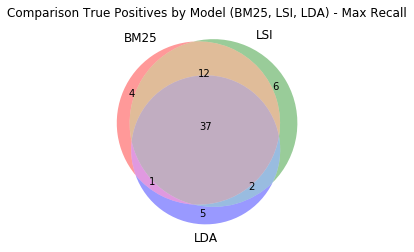

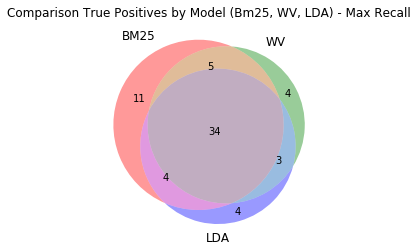

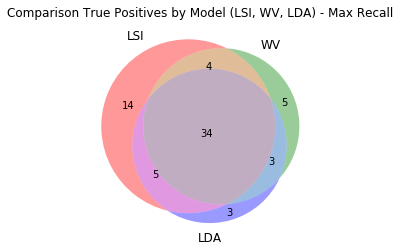

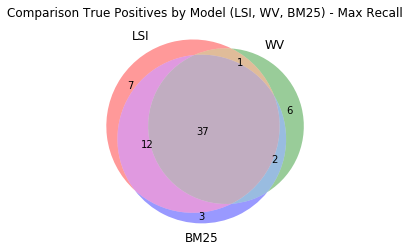

In [30]:
group = evals_df_4.groupby('model').perc_recall.max()
print(group)
print()

bm25_max_recall = group[group.index == 'bm25'].values[0]
lsi_max_recall = group[group.index == 'lsi'].values[0]
lda_max_recall = group[group.index == 'lda'].values[0]
wv_max_recall = group[group.index == 'wordvector'].values[0]

bm25_tp_set_max_recall = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_max_recall))
lsi_tp_set_max_recall = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_max_recall))
lda_tp_set_max_recall = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_max_recall))
wv_tp_set_max_recall = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_max_recall))

venn3([bm25_tp_set_max_recall, lsi_tp_set_max_recall, lda_tp_set_max_recall], ['BM25','LSI','LDA'])
plt.title('Comparison True Positives by Model (BM25, LSI, LDA) - Max Recall')
plt.show()

venn3([bm25_tp_set_max_recall, wv_tp_set_max_recall, lda_tp_set_max_recall], ['BM25','WV','LDA'])
plt.title('Comparison True Positives by Model (Bm25, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_tp_set_max_recall, wv_tp_set_max_recall, lda_tp_set_max_recall], ['LSI','WV','LDA'])
plt.title('Comparison True Positives by Model (LSI, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_tp_set_max_recall, wv_tp_set_max_recall, bm25_tp_set_max_recall], ['LSI','WV','BM25'])
plt.title('Comparison True Positives by Model (LSI, WV, BM25) - Max Recall')
plt.show()

##### Exclusive Cases

In [32]:
print("BM25 Exclusive TP:")
bm25_exc_set_max_recall = bm25_tp_set_max_recall - lsi_tp_set_max_recall - lda_tp_set_max_recall - wv_tp_set_max_recall
display(bm25_exc_set_max_recall)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set_max_recall)))

print("\n\nLSI Exclusive TP:")
lsi_exc_set_max_recall = lsi_tp_set_max_recall - bm25_tp_set_max_recall - lda_tp_set_max_recall - wv_tp_set_max_recall
display(lsi_exc_set_max_recall)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set_max_recall)))

print("\n\nLDA Exclusive TP:")
lda_exc_set_max_recall = lda_tp_set_max_recall - lsi_tp_set_max_recall - bm25_tp_set_max_recall - wv_tp_set_max_recall
display(lda_exc_set_max_recall)
print("len(lda_exc_set): {}".format(len(lda_exc_set_max_recall)))

print("\n\nWV Exclusive TP:")
wv_exc_set_max_recall = wv_tp_set_max_recall - lda_tp_set_max_recall - lsi_tp_set_max_recall - bm25_tp_set_max_recall
display(wv_exc_set_max_recall)
print("len(wv_exc_set): {}".format(len(wv_exc_set_max_recall)))

BM25 Exclusive TP:


{('downloads_dropmaker', 1432915), ('pointer_lock_api', 1314643)}

len(bm25_exc_set): 2


LSI Exclusive TP:


{('browser_customization', 1301784),
 ('browser_customization', 1344446),
 ('pdf_viewer', 1365887),
 ('tts_in_rm', 1335538),
 ('webgl_comp', 1295502)}

len(lsi_exc_set): 5


LDA Exclusive TP:


{('webgl_comp', 1312018), ('webgl_comp', 1365887)}

len(lda_exc_set): 2


WV Exclusive TP:


{('apz_async_scrolling', 1295502),
 ('context_menu', 1303339),
 ('zoom_indicator', 1316126)}

len(wv_exc_set): 3


##### True Positives Amount by Model

In [33]:
print("LSI TP Amount: {}".format(len(lsi_tp_set_max_recall)))
print("LDA TP Amount: {}".format(len(lda_tp_set_max_recall)))
print("BM25 TP Amount: {}".format(len(bm25_tp_set_max_recall)))
print("WV TP Amount: {}".format(len(wv_tp_set_max_recall)))

LSI TP Amount: 57
LDA TP Amount: 45
BM25 TP Amount: 54
WV TP Amount: 46


#### Max-Min Recall Comparison by Model

In [35]:
print("LSI")
display(lsi_tp_set_max_recall - lsi_tp_set_min_recall)

print("LDA")
display(lda_tp_set_max_recall - lda_tp_set_min_recall)

print("BM25")
display(bm25_tp_set_max_recall - bm25_tp_set_min_recall)

print("WV")
display(wv_tp_set_max_recall - wv_tp_set_min_recall)

LSI


{('browser_customization', 1301784),
 ('browser_customization', 1318903),
 ('browser_customization', 1344446),
 ('browser_customization', 1353831),
 ('browser_customization', 1357458),
 ('browser_customization', 1451475),
 ('context_menu', 1270983),
 ('context_menu', 1289240),
 ('context_menu', 1299458),
 ('context_menu', 1306639),
 ('context_menu', 1313969),
 ('context_menu', 1365887),
 ('downloads_dropmaker', 1292573),
 ('indicator_device_perm', 1296322),
 ('indicator_device_perm', 1296861),
 ('indicator_device_perm', 1345687),
 ('new_awesome_bar', 1271607),
 ('new_awesome_bar', 1276120),
 ('new_awesome_bar', 1279143),
 ('new_awesome_bar', 1291770),
 ('new_awesome_bar', 1296366),
 ('new_awesome_bar', 1297336),
 ('new_awesome_bar', 1297374),
 ('new_awesome_bar', 1297976),
 ('new_awesome_bar', 1305737),
 ('new_awesome_bar', 1309856),
 ('new_awesome_bar', 1311998),
 ('new_awesome_bar', 1319119),
 ('new_awesome_bar', 1328913),
 ('new_awesome_bar', 1339497),
 ('new_awesome_bar', 1352539),

LDA


{('context_menu', 1248267),
 ('context_menu', 1270983),
 ('context_menu', 1289240),
 ('context_menu', 1299458),
 ('context_menu', 1306639),
 ('context_menu', 1313969),
 ('context_menu', 1365887),
 ('downloads_dropmaker', 1287384),
 ('flac_support', 1295502),
 ('flash_support', 1295502),
 ('new_awesome_bar', 1264988),
 ('new_awesome_bar', 1271607),
 ('new_awesome_bar', 1276120),
 ('new_awesome_bar', 1278388),
 ('new_awesome_bar', 1279143),
 ('new_awesome_bar', 1279864),
 ('new_awesome_bar', 1291770),
 ('new_awesome_bar', 1293308),
 ('new_awesome_bar', 1294733),
 ('new_awesome_bar', 1294887),
 ('new_awesome_bar', 1296366),
 ('new_awesome_bar', 1297336),
 ('new_awesome_bar', 1297374),
 ('new_awesome_bar', 1297976),
 ('new_awesome_bar', 1301421),
 ('new_awesome_bar', 1305737),
 ('new_awesome_bar', 1309856),
 ('new_awesome_bar', 1311998),
 ('new_awesome_bar', 1313778),
 ('new_awesome_bar', 1328913),
 ('new_awesome_bar', 1334844),
 ('new_awesome_bar', 1335992),
 ('new_awesome_bar', 1337682),

BM25


{('apz_async_scrolling', 1287687),
 ('browser_customization', 1318903),
 ('browser_customization', 1353831),
 ('browser_customization', 1357458),
 ('browser_customization', 1451475),
 ('context_menu', 1289240),
 ('context_menu', 1306639),
 ('context_menu', 1313969),
 ('context_menu', 1365887),
 ('downloads_dropmaker', 1292573),
 ('downloads_dropmaker', 1432915),
 ('flac_support', 1295502),
 ('new_awesome_bar', 1271607),
 ('new_awesome_bar', 1279143),
 ('new_awesome_bar', 1297336),
 ('new_awesome_bar', 1297374),
 ('new_awesome_bar', 1297976),
 ('new_awesome_bar', 1305737),
 ('new_awesome_bar', 1319119),
 ('new_awesome_bar', 1328913),
 ('new_awesome_bar', 1352539),
 ('new_awesome_bar', 1432915),
 ('new_awesome_bar', 1451475),
 ('pointer_lock_api', 1314643),
 ('tts_in_rm', 1357458),
 ('w10_comp', 1303339)}

WV


{('apz_async_scrolling', 1295502),
 ('context_menu', 1270983),
 ('context_menu', 1303339),
 ('context_menu', 1313969),
 ('context_menu', 1365887),
 ('flash_support', 1295502),
 ('new_awesome_bar', 1264988),
 ('new_awesome_bar', 1271607),
 ('new_awesome_bar', 1278388),
 ('new_awesome_bar', 1279143),
 ('new_awesome_bar', 1293308),
 ('new_awesome_bar', 1294733),
 ('new_awesome_bar', 1296366),
 ('new_awesome_bar', 1297336),
 ('new_awesome_bar', 1297374),
 ('new_awesome_bar', 1297976),
 ('new_awesome_bar', 1305737),
 ('new_awesome_bar', 1309856),
 ('new_awesome_bar', 1311998),
 ('new_awesome_bar', 1313778),
 ('new_awesome_bar', 1319119),
 ('new_awesome_bar', 1328913),
 ('new_awesome_bar', 1335992),
 ('new_awesome_bar', 1339497),
 ('new_awesome_bar', 1352539),
 ('new_awesome_bar', 1357458),
 ('new_awesome_bar', 1432915),
 ('new_awesome_bar', 1451475),
 ('tts_in_rm', 1357458),
 ('w10_comp', 1300738),
 ('w10_comp', 1303339),
 ('zoom_indicator', 1305195),
 ('zoom_indicator', 1316126)}